In [ ]:
import torch.nn as nn
from collections import OrderedDict
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.datasets.mnist import MNIST
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from tqdm import tqdm
from matplotlib import pyplot as plt
import numpy

In [ ]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
numpy.set_printoptions(threshold=numpy.inf)

## 定義網路架構

In [ ]:
# @title 預設標題文字
import torch
import torch.nn as nn
from collections import OrderedDict

class LeNet5(nn.Module):
    """
    Input - batch_size x1 x32 x32
    Output - batch_size x10
    """
    def __init__(self, c1_out_channels):
        super(LeNet5, self).__init__()

        self.c1_1 = nn.Sequential(OrderedDict([
            ('c1', nn.Conv2d(1, c1_out_channels, kernel_size=(5, 5))),
        ]))
        self.c1_2 = nn.Sequential(OrderedDict([
            ('relu1', nn.ReLU()),
        ]))
        self.c1_3 = nn.Sequential(OrderedDict([
            ('s2', nn.MaxPool2d(kernel_size=(2, 2), stride=2))
        ]))
        self.c2 = nn.Sequential(OrderedDict([
            ('c3', nn.Conv2d(6, 16, kernel_size=(5, 5))),
            ('relu2', nn.ReLU()),
            ('s4', nn.MaxPool2d(kernel_size=(2, 2), stride=2))
        ]))
        self.f3 = nn.Sequential(OrderedDict([
            ('f5', nn.Linear(5*5*16, 120)),
            ('relu3', nn.ReLU())
        ]))
        self.f4 = nn.Sequential(OrderedDict([
            ('f6', nn.Linear(120, 84)),
            ('relu4', nn.ReLU())
        ]))
        self.output = nn.Linear(in_features=84, out_features=10)

    def customActivation(self, img, x):
      if not self.training:  # Apply custom activation only during testing
        # 將圓心移到原點
          kernel_weights = self.c1_1.c1.weight  # Get the convolutional layer weights
          kernel_sum = -torch.sum(kernel_weights, dim=(2, 3), keepdim=True).unsqueeze(0).squeeze(-1)
          # print(kernel_sum.shape)
          kernel_sum = kernel_sum.repeat(img.shape[0], 1, 28, 28)
          # print(kernel_sum.shape)

          # print(x.shape)
          # d = x + kernel_sum
          # print(d, d.shape)

          # x平均
          # 使用 torch.unfold 提取子區域並展開
          unfolded_tensor = torch.nn.functional.unfold(img, (5,5), stride=1).permute(0, 2, 1)
          # print(unfolded_tensor.shape)
          # unfolded_tensor 的形狀為 (1, 25, 676)，其中 25 是子區域的數量，（32-5+1)^2 = 676 是每個子區域展開後的元素數量
          # 將展開的 tensor 轉換成您想要的形狀，例如 (1, 28, 28, 5, 5)
          reshaped_tensor = unfolded_tensor.view(img.size(0), 28, 28, 5, 5)
          x_mean = reshaped_tensor.mean(dim=(3, 4), keepdim=True).squeeze(-1).squeeze(-1).unsqueeze(1).repeat(1, kernel_weights.shape[0], 1, 1)
          # print(x_mean.shape, x_mean)

          # 內積
          dot = x_mean * kernel_sum
          # print(dot.shape, dot)

          activated_output = x + dot
          return activated_output
      return x

    def forward(self, img):
        output = self.c1_1(img)
        output = self.customActivation(img, output)
        output = self.c1_2(output)
        output = self.c1_3(output)
        output = self.c2(output)
        output = torch.flatten(output, 1)
        output = self.f3(output)
        output = self.f4(output)
        output = self.output(output)
        return output


In [ ]:
# @title 有化成單位向量


# class Normalize(nn.Module):
#     def __init__(self):
#         super(Normalize, self).__init__()

#     def forward(self, input, img, kernel_weights, kernel_sum, x_mean):
#       # 將向量長度變成1(輸出0~1)
#         # a範數
#         reshape_kernel_weights = kernel_weights.view(kernel_weights.shape[0], kernel_weights.shape[1], 25)
#         kernel_sum = torch.tensor([k[0][0] for k in kernel_sum[0]]).unsqueeze(-1).unsqueeze(-1)
#         reshape_kernel_weights = torch.cat((reshape_kernel_weights,kernel_sum), 2)
#         a_norm = reshape_kernel_weights.norm(p=2, dim=(2), keepdim=True).unsqueeze(0).unsqueeze(-1)  #b,6,1,1,1

#         # x範數
#         unfolded_tensor = torch.nn.functional.unfold(img, (5,5), stride=1).permute(0, 2, 1)
#         reshaped_tensor = unfolded_tensor.view(img.size(0), input.shape[2], input.shape[2], 25).unsqueeze(1)
#         x_mean = torch.tensor([k[0] for k in x_mean.numpy()]).unsqueeze(1).unsqueeze(-1)
#         reshaped_tensor = torch.cat((reshaped_tensor,x_mean), 4)
#         x_norm = reshaped_tensor.norm(p=2, dim=(4)).unsqueeze(1) #b,1,1,28,28

#         self.length = torch.sum((x_norm * a_norm), 2)

#         # activated_output = torch.abs(input) / (torch.sum((x_norm * a_norm), 2) - 1e-9)
#         activated_output = input / self.length
#         activated_output[torch.isnan(activated_output)] = 0
#         activated_output[torch.isinf(activated_output)] = 0
#         return activated_output

#     def backward(self, eta):
#         eta /= self.length
#         eta[torch.isnan(eta)] = 0
#         eta[torch.isinf(eta)] = 0
#         print(eta)
#         return eta

import torch
import torch.nn as nn
from collections import OrderedDict

class LeNet5(nn.Module):
    """
    Input - batch_size x1 x32 x32
    Output - batch_size x10
    """
    def __init__(self, c1_out_channels):
        super(LeNet5, self).__init__()

        self.c1_1 = nn.Sequential(OrderedDict([
            ('c1', nn.Conv2d(1, c1_out_channels, kernel_size=(5, 5))),
        ]))
        self.c1_2 = nn.Sequential(OrderedDict([
            ('relu1', nn.ReLU()),
        ]))
        self.c1_3 = nn.Sequential(OrderedDict([
            ('s2', nn.MaxPool2d(kernel_size=(2, 2), stride=2))
        ]))
        self.c2 = nn.Sequential(OrderedDict([
            ('c3', nn.Conv2d(6, 16, kernel_size=(5, 5))),
            ('relu2', nn.ReLU()),
            ('s4', nn.MaxPool2d(kernel_size=(2, 2), stride=2))
        ]))
        self.f3 = nn.Sequential(OrderedDict([
            ('f5', nn.Linear(5*5*16, 120)),
            ('relu3', nn.ReLU())
        ]))
        self.f4 = nn.Sequential(OrderedDict([
            ('f6', nn.Linear(120, 84)),
            ('relu4', nn.ReLU())
        ]))
        self.output = nn.Linear(in_features=84, out_features=10)

    def customActivation(self, img, x):
      # if not self.training:  # Apply custom activation only during testing
        # 將圓心移到原點
          kernel_weights = self.c1_1.c1.weight  # Get the convolutional layer weights
          kernel_sum = -torch.sum(kernel_weights, dim=(2, 3), keepdim=True).unsqueeze(0).squeeze(-1)
          # print(kernel_sum.shape)
          kernel_sum = kernel_sum.repeat(img.shape[0], 1, 28, 28)
          # print(kernel_sum.shape)

          # x平均
          # 使用 torch.unfold 提取子區域並展開
          unfolded_tensor = torch.nn.functional.unfold(img, (5,5), stride=1).permute(0, 2, 1)
          # print(unfolded_tensor.shape)
          reshaped_tensor = unfolded_tensor.view(img.size(0), 28, 28, 5, 5)
          x_mean = reshaped_tensor.mean(dim=(3, 4), keepdim=True).squeeze(-1).squeeze(-1).unsqueeze(1).repeat(1, kernel_weights.shape[0], 1, 1)
          # print(x_mean.shape, x_mean)

          # 內積
          dot = x_mean * kernel_sum
          # print(dot.shape, dot)

          activated_output = x + dot
          return activated_output, x_mean, kernel_sum
      # return x, _, _

    def normalize(self, img, x, x_mean, kernel_sum):
      if not self.training:  # Apply custom activation only during testing
        # 將向量長度變成1
          # print(x.shape, x)

          # a範數
          kernel_weights = self.c1_1.c1.weight  # Get the convolutional layer weights
          # kernel_weights = kernel_weights.unsqueeze(0).unsqueeze(2).repeat(img.size(0), 1, 28, 28, 1, 1).view(img.size(0), -1, 28, 28, 25)
          # kernel_sum = kernel_sum.unsqueeze(-1)
          # print(kernel_sum.shape, kernel_weights.shape, kernel_weights)
          # new_a = torch.cat((kernel_weights,kernel_sum), 4)
          a_norm = kernel_weights.norm(p=2, dim=(2,3)).unsqueeze(0).unsqueeze(-1).repeat(img.size(0), 1, 28, 28)
          print(a_norm.shape, a_norm)

          # x範數
          unfolded_tensor = torch.nn.functional.unfold(img, (5,5), stride=1).permute(0, 2, 1)
          reshaped_tensor = unfolded_tensor.view(img.size(0), 28, 28, 25)
          # .unsqueeze(1).repeat(1, kernel_weights.shape[1], 1, 1, 1)
          # x_mean = x_mean.unsqueeze(-1)
          # print(reshaped_tensor.shape, x_mean.shape, x_mean)
          # new_x = torch.cat((reshaped_tensor,x_mean), 4)
          # print(new_x.shape, new_x)
          x_norm = reshaped_tensor.norm(p=2, dim=(3)).unsqueeze(1).repeat(1, kernel_weights.shape[0], 1, 1)
          # print(x_norm.shape, x_norm)

          activated_output = x * (x_norm * a_norm)
          # activated_output = torch.exp(torch.log(x) + (torch.log(x_norm) + torch.log(a_norm)))
          return activated_output
      return x

    def forward(self, img):
        output = self.c1_1(img)
        output, x_mean, kernel_sum = self.customActivation(img, output)
        output = self.c1_2(output)
        output = self.normalize(img, output, x_mean, kernel_sum)
        output = self.c1_3(output)
        output = self.c2(output)
        output = torch.flatten(output, 1)
        output = self.f3(output)
        output = self.f4(output)
        output = self.output(output)
        return output


# Create an instance of the LeNet5 model
model = LeNet5(c1_out_channels=6)  # Set the number of output channels for the first convolutional layer

In [ ]:
# @title 有化成單位向量
import torch
import torch.nn as nn
from collections import OrderedDict

class LeNet5(nn.Module):
    """
    Input - batch_size x1 x32 x32
    Output - batch_size x10
    """
    def __init__(self, c1_out_channels):
        super(LeNet5, self).__init__()

        self.c1_1 = nn.Sequential(OrderedDict([
            ('c1', nn.Conv2d(1, c1_out_channels, kernel_size=(5, 5))),
        ]))
        self.c1_2 = nn.Sequential(OrderedDict([
            ('relu1', nn.ReLU()),
        ]))
        self.c1_3 = nn.Sequential(OrderedDict([
            ('s2', nn.MaxPool2d(kernel_size=(2, 2), stride=2))
        ]))
        self.c2_1 = nn.Sequential(OrderedDict([
            ('c3', nn.Conv2d(6, 16, kernel_size=(5, 5))),
            ('relu2', nn.ReLU()),
        ]))
        self.c2_2 = nn.Sequential(OrderedDict([
            ('s4', nn.MaxPool2d(kernel_size=(2, 2), stride=2))
        ]))
        self.f3 = nn.Sequential(OrderedDict([
            ('f5', nn.Linear(5*5*16, 120)),
            ('relu3', nn.ReLU())
        ]))
        self.f4 = nn.Sequential(OrderedDict([
            ('f6', nn.Linear(120, 84)),
            ('relu4', nn.ReLU())
        ]))
        self.output = nn.Linear(in_features=84, out_features=10)

    def customActivation(self, img, x):
      # if not self.training:  # Apply custom activation only during testing
        # 將圓心移到原點
          kernel_weights = self.c1_1.c1.weight  # Get the convolutional layer weights
          kernel_sum = -torch.sum(kernel_weights, dim=(2, 3), keepdim=True).unsqueeze(0).squeeze(-1)
          # print(kernel_sum.shape)
          kernel_sum = kernel_sum.repeat(img.shape[0], 1, 28, 28)
          # print(kernel_sum.shape)

          # x平均
          # 使用 torch.unfold 提取子區域並展開
          unfolded_tensor = torch.nn.functional.unfold(img, (5,5), stride=1).permute(0, 2, 1)
          # print(unfolded_tensor.shape)
          reshaped_tensor = unfolded_tensor.view(img.size(0), 28, 28, 5, 5)
          x_mean = reshaped_tensor.mean(dim=(3, 4), keepdim=True).squeeze(-1).squeeze(-1).unsqueeze(1).repeat(1, kernel_weights.shape[0], 1, 1)
          # print(x_mean.shape, x_mean)

          # 內積
          dot = x_mean * kernel_sum
          # print(dot.shape, dot)

          activated_output = x + dot
          return activated_output, x_mean, kernel_sum
      # return x, _, _

    def normalize(self, img, input, x_mean, kernel_sum, kernel_weights):
      if not self.training:  # Apply custom activation only during testing
        # 將向量長度變成1
          # print(input.shape, input)

          # a範數
          # kernel_weights = self.c1_1.c1.weight  # Get the convolutional layer weights
          reshape_kernel_weights = kernel_weights.view(kernel_weights.shape[0], kernel_weights.shape[1], 25)
          # print(kernel_weights[0])
          # kernel_sum = torch.tensor([k[0][0] for k in kernel_sum[0]]).unsqueeze(-1)
          # print(kernel_weights.shape, kernel_sum.shape, kernel_sum)
          # new_a = torch.cat((reshape_kernel_weights,kernel_sum), 1)
          # print(new_a.shape, new_a)
          # a_norm = new_a.norm(p=2, dim=(1), keepdim=True).unsqueeze(0).unsqueeze(-1).repeat(img.size(0), 1, 28, 28)
          a_norm = reshape_kernel_weights.norm(p=2, dim=(2), keepdim=True).unsqueeze(0).unsqueeze(-1).repeat(img.size(0), 1, 1, input.shape[2], input.shape[2])
          # print(a_norm.shape)

          # x範數
          # img = torch.sum(img, (1), keepdim=True)
          unfolded_tensor = torch.nn.functional.unfold(img, (5,5), stride=1).permute(0, 2, 1)
          # print(unfolded_tensor.shape)
          reshaped_tensor = unfolded_tensor.reshape(img.size(0), -1, input.shape[2], input.shape[2], 25)
          # print(reshaped_tensor.shape)
          # .unsqueeze(1).repeat(1, kernel_weights.shape[1], 1, 1, 1)
          # print([k[0] for k in x_mean])
          # x_mean = torch.tensor([k[0] for k in x_mean.numpy()]).unsqueeze(-1)
          # print(reshaped_tensor.shape, x_mean.shape, x_mean)
          # new_x = torch.cat((reshaped_tensor,x_mean), 3)
          # print(new_x.shape, new_x)
          # x_norm = new_x.norm(p=2, dim=(3)).unsqueeze(1).repeat(1, kernel_weights.shape[0], 1, 1)
          x_norm = reshaped_tensor.norm(p=2, dim=(4)).unsqueeze(1).repeat(1, kernel_weights.shape[0], 1, 1, 1)
          # print(x_norm.shape)

          activated_output = input * torch.sum((x_norm * a_norm), 2)
          # activated_output = torch.exp(torch.log(x) + (torch.log(x_norm) + torch.log(a_norm)))
          return activated_output
      return input

    def forward(self, img):
        output = self.c1_1(img)
        output, x_mean, kernel_sum = self.customActivation(img, output)
        output = self.c1_2(output)
        output = self.normalize(img, output, x_mean, kernel_sum, self.c1_1.c1.weight)
        img1 = self.c1_3(output)
        output = self.c2_1(img1)
        output = self.normalize(img1, output, x_mean, kernel_sum, self.c2_1.c3.weight)
        output = self.c2_2(output)
        output = torch.flatten(output, 1)
        output = self.f3(output)
        output = self.f4(output)
        output = self.output(output)
        return output


# Create an instance of the LeNet5 model
model = LeNet5(c1_out_channels=6)  # Set the number of output channels for the first convolutional layer

In [ ]:
# @title 沒有化為單位向量
import torch
import torch.nn as nn
from collections import OrderedDict

class LeNet5(nn.Module):
    """
    Input - batch_size x1 x32 x32
    Output - batch_size x10
    """
    def __init__(self, c1_out_channels):
        super(LeNet5, self).__init__()

        self.c1_1 = nn.Sequential(OrderedDict([
            ('c1', nn.Conv2d(1, c1_out_channels, kernel_size=(5, 5))),
        ]))
        self.c1_2 = nn.Sequential(OrderedDict([
            ('relu1', nn.ReLU()),
        ]))
        self.c1_3 = nn.Sequential(OrderedDict([
            ('s2', nn.MaxPool2d(kernel_size=(2, 2), stride=2))
        ]))
        self.c2 = nn.Sequential(OrderedDict([
            ('c3', nn.Conv2d(6, 16, kernel_size=(5, 5))),
            ('relu2', nn.ReLU()),
            ('s4', nn.MaxPool2d(kernel_size=(2, 2), stride=2))
        ]))
        self.f3 = nn.Sequential(OrderedDict([
            ('f5', nn.Linear(5*5*16, 120)),
            ('relu3', nn.ReLU())
        ]))
        self.f4 = nn.Sequential(OrderedDict([
            ('f6', nn.Linear(120, 84)),
            ('relu4', nn.ReLU())
        ]))
        self.output = nn.Linear(in_features=84, out_features=10)

    def customActivation(self, img, x):
      # if not self.training:  # Apply custom activation only during testing
      # 將圓心移到原點(向量擴增)
        # 權重總和
          kernel_weights = self.c1_1.c1.weight  # Get the convolutional layer weights
          kernel_sum = -torch.sum(kernel_weights, dim=(2, 3), keepdim=True).unsqueeze(0).squeeze(-1)
          # print(kernel_sum.shape)
          kernel_sum = kernel_sum.repeat(img.shape[0], 1, 28, 28)
          # print(kernel_sum.shape)

        # x平均
          # 使用 torch.unfold 提取子區域並展開
          unfolded_tensor = torch.nn.functional.unfold(img, (5,5), stride=1).permute(0, 2, 1)
          # print(unfolded_tensor.shape)
          # unfolded_tensor 的形狀為 (1, 25, 676)，其中 25 是子區域的數量，（32-5+1)^2 = 676 是每個子區域展開後的元素數量
          # 將展開的 tensor 轉換成您想要的形狀，例如 (1, 28, 28, 5, 5)
          reshaped_tensor = unfolded_tensor.view(img.size(0), 28, 28, 5, 5)
          x_mean = reshaped_tensor.mean(dim=(3, 4), keepdim=True).squeeze(-1).squeeze(-1).unsqueeze(1).repeat(1, kernel_weights.shape[0], 1, 1)
          # print(x_mean.shape, x_mean)

        # 內積
          dot = x_mean * kernel_sum
          # print(dot.shape, dot)

          activated_output = x + dot
          return activated_output
      # return x

    def forward(self, img):
        output = self.c1_1(img)
        output = self.customActivation(img, output)
        output = self.c1_2(output)
        output = self.c1_3(output)
        output = self.c2(output)
        output = torch.flatten(output, 1)
        output = self.f3(output)
        output = self.f4(output)
        output = self.output(output)
        return output

# Create an instance of the LeNet5 model
model = LeNet5(c1_out_channels=6)  # Set the number of output channels for the first convolutional layer

In [ ]:
# @title 有化成單位向量
import torch
import torch.nn as nn
from collections import OrderedDict

class Normalize(nn.Module):
    def __init__(self):
        super(Normalize, self).__init__()

    def forward(self, input, img, kernel_weights):
      if not self.training:  # Apply custom activation only during testing
      # 將向量長度變成1
          kernel_weights = kernel_weights.detach()
          # a範數
          reshape_kernel_weights = kernel_weights.view(kernel_weights.shape[0], kernel_weights.shape[1], 25)
          a_norm = reshape_kernel_weights.norm(p=2, dim=(2), keepdim=True).unsqueeze(0).unsqueeze(-1).repeat(img.size(0), 1, 1, input.shape[2], input.shape[2])

          # x範數
          unfolded_tensor = torch.nn.functional.unfold(img.detach(), (5,5), stride=1).permute(0, 2, 1)
          reshaped_tensor = unfolded_tensor.reshape(img.size(0), -1, input.shape[2], input.shape[2], 25)
          x_norm = reshaped_tensor.norm(p=2, dim=(4)).unsqueeze(1).repeat(1, kernel_weights.shape[0], 1, 1, 1)

          activated_output = input * torch.sum((x_norm * a_norm), 2).detach()
          return activated_output
      return input


class LeNet5(nn.Module):
    """
    Input - batch_size x1 x32 x32
    Output - batch_size x10
    """
    def __init__(self, c1_out_channels):
        super(LeNet5, self).__init__()

        self.c1_1 = nn.Sequential(OrderedDict([
            ('c1', nn.Conv2d(1, c1_out_channels, kernel_size=(5, 5))),
        ]))
        self.c1_2 = nn.Sequential(OrderedDict([
            ('relu1', nn.ReLU()),
        ]))
        self.c1_3 = nn.Sequential(OrderedDict([
            ('s2', nn.MaxPool2d(kernel_size=(2, 2), stride=2))
        ]))
        self.c2_1 = nn.Sequential(OrderedDict([
            ('c3', nn.Conv2d(6, 16, kernel_size=(5, 5))),
            ('relu2', nn.ReLU()),
        ]))
        self.c2_2 = nn.Sequential(OrderedDict([
            ('s4', nn.MaxPool2d(kernel_size=(2, 2), stride=2))
        ]))
        self.f3 = nn.Sequential(OrderedDict([
            ('f5', nn.Linear(5*5*16, 120)),
            ('relu3', nn.ReLU())
        ]))
        self.f4 = nn.Sequential(OrderedDict([
            ('f6', nn.Linear(120, 84)),
            ('relu4', nn.ReLU())
        ]))
        self.output = nn.Linear(in_features=84, out_features=10)

        self.normalize = Normalize()

    def customActivation(self, img, x):
      # if not self.training:  # Apply custom activation only during testing
        # 將圓心移到原點
          kernel_weights = self.c1_1.c1.weight  # Get the convolutional layer weights
          kernel_sum = -torch.sum(kernel_weights, dim=(2, 3), keepdim=True).unsqueeze(0).squeeze(-1)
          # print(kernel_sum.shape)
          kernel_sum = kernel_sum.repeat(img.shape[0], 1, 28, 28)
          # print(kernel_sum.shape)

          # x平均
          # 使用 torch.unfold 提取子區域並展開
          unfolded_tensor = torch.nn.functional.unfold(img, (5,5), stride=1).permute(0, 2, 1)
          # print(unfolded_tensor.shape)
          reshaped_tensor = unfolded_tensor.view(img.size(0), 28, 28, 5, 5)
          x_mean = reshaped_tensor.mean(dim=(3, 4), keepdim=True).squeeze(-1).squeeze(-1).unsqueeze(1).repeat(1, kernel_weights.shape[0], 1, 1)
          # print(x_mean.shape, x_mean)

          # 內積
          dot = x_mean * kernel_sum
          # print(dot.shape, dot)

          activated_output = x + dot
          return activated_output
      # return x, _, _

    def forward(self, img):
        output = self.c1_1(img)
        output = self.customActivation(img, output)
        output = self.c1_2(output)
        # output = self.normalize(output, img, self.c1_1.c1.weight)
        img1 = self.c1_3(output)
        output = self.c2_1(img1)
        # output = self.normalize(output, img1, self.c2_1.c3.weight)
        output = self.c2_2(output)
        output = torch.flatten(output, 1)
        output = self.f3(output)
        output = self.f4(output)
        output = self.output(output)
        return output


# Create an instance of the LeNet5 model
model = LeNet5(c1_out_channels=6)  # Set the number of output channels for the first convolutional layer

In [ ]:
# @title BN層
class BN_LeNet5(nn.Module):
    """
    Input - batch_size x1 x32 x32
    Output - batch_size x10
    """
    def __init__(self):
        super(BN_LeNet5, self).__init__()

        self.c1_1 = nn.Sequential(OrderedDict([
            ('c1', nn.Conv2d(1, 6, kernel_size=(5, 5))),
        ]))
        self.c1_2 = nn.Sequential(OrderedDict([
            ('bn1', nn.BatchNorm2d(6)),
            ('relu1', nn.ReLU()),
        ]))
        self.c1_3 = nn.Sequential(OrderedDict([
            ('s2', nn.MaxPool2d(kernel_size=(2, 2), stride=2))
        ]))
        self.c2 = nn.Sequential(OrderedDict([
            ('c3', nn.Conv2d(6, 16, kernel_size=(5, 5))),
            ('bn2', nn.BatchNorm2d(16)),
            ('relu2', nn.ReLU()),
            ('s4', nn.MaxPool2d(kernel_size=(2, 2), stride=2))
        ]))
        self.f3 = nn.Sequential(OrderedDict([
            ('f5', nn.Linear(5*5*16, 120)),
            ('bn3', nn.BatchNorm1d(120)),
            ('relu3', nn.ReLU())
        ]))
        self.f4 = nn.Sequential(OrderedDict([
            ('f6', nn.Linear(120, 84)),
            ('bn4', nn.BatchNorm1d(84)),
            ('relu4', nn.ReLU())
        ]))
        self.output = nn.Linear(in_features=84, out_features=10)

    def forward(self, img):
        output = self.c1_1(img)
        # output = self.translate(output, img, self.c1_1.c1.weight)
        output = self.c1_2(output)
        output = self.c1_3(output)
        output = self.c2(output)
        output = torch.flatten(output, 1)
        output = self.f3(output)
        output = self.f4(output)
        output = self.output(output)
        return output


In [ ]:
# 球面平移
class Translate(nn.Module):
    def __init__(self):
        super(Translate, self).__init__()

    def forward(self, input, img, kernel_weights):
      # 將圓心移到平均(向量擴增)
        # 權重總和
          kernel_sum = -torch.sum(kernel_weights, dim=(2, 3), keepdim=True).unsqueeze(0).squeeze(-1)
          kernel_sum = kernel_sum.repeat(img.shape[0], 1, 28, 28)

        # x平均
          # 使用 torch.unfold 提取子區域並展開
          unfolded_tensor = torch.nn.functional.unfold(img, (5,5), stride=1).permute(0, 2, 1)
          # unfolded_tensor 的形狀為 (batch_size, 784, 25)，其中 （32-5+1)^2 = 784 是子區域的數量， 25 是每個子區域展開後的元素數量
          # 將展開的 tensor 轉換成 (batch_size, 28, 28, 5, 5)
          reshaped_tensor = unfolded_tensor.view(img.size(0), 28, 28, 5, 5)
          x_mean = reshaped_tensor.mean(dim=(3, 4), keepdim=True).squeeze(-1).squeeze(-1).unsqueeze(1).repeat(1, kernel_weights.shape[0], 1, 1)

        # 內積
          dot = x_mean * kernel_sum

          activated_output = input + dot
          return activated_output


In [ ]:
# @title 原始LeNet5網路
class LeNet5(nn.Module):
    """
    Input - batch_size x1 x32 x32
    Output - batch_size x10
    """
    def __init__(self):
        super(LeNet5, self).__init__()

        self.c1_1 = nn.Sequential(OrderedDict([
            ('c1', nn.Conv2d(1, 6, kernel_size=(5, 5))),
        ]))
        self.c1_2 = nn.Sequential(OrderedDict([
            ('relu1', nn.ReLU()),
        ]))
        self.c1_3 = nn.Sequential(OrderedDict([
            ('s2', nn.MaxPool2d(kernel_size=(2, 2), stride=2))
        ]))
        self.c2_1 = nn.Sequential(OrderedDict([
            ('c3', nn.Conv2d(6, 16, kernel_size=(5, 5))),
            ('relu2', nn.ReLU()),
        ]))
        self.c2_2 = nn.Sequential(OrderedDict([
            ('s4', nn.MaxPool2d(kernel_size=(2, 2), stride=2))
        ]))
        self.f3 = nn.Sequential(OrderedDict([
            ('f5', nn.Linear(5*5*16, 120)),
            ('relu3', nn.ReLU())
        ]))
        self.f4 = nn.Sequential(OrderedDict([
            ('f6', nn.Linear(120, 84)),
            ('relu4', nn.ReLU())
        ]))
        self.output = nn.Linear(in_features=84, out_features=10)

    def forward(self, img):
        output = self.c1_1(img)
        output = self.c1_2(output)
        output = self.c1_3(output)
        output = self.c2_1(output)
        output = self.c2_2(output)
        output = torch.flatten(output, 1)
        output = self.f3(output)
        output = self.f4(output)
        output = self.output(output)
        return output

In [ ]:
# @title 球面平移網路
# 球面平移
class Translate(nn.Module):
    def __init__(self):
        super(Translate, self).__init__()

    def forward(self, input, img, kernel_weights):
      # 將圓心移到平均(向量擴增)
        # 權重總和
          kernel_sum = -torch.sum(kernel_weights, dim=(2, 3), keepdim=True).unsqueeze(0).squeeze(-1)
          kernel_sum = kernel_sum.repeat(img.shape[0], 1, 28, 28)

        # x平均
          # 使用 torch.unfold 提取子區域並展開
          unfolded_tensor = torch.nn.functional.unfold(img, (5,5), stride=1).permute(0, 2, 1)
          # unfolded_tensor 的形狀為 (batch_size, 784, 25)，其中 （32-5+1)^2 = 784 是子區域的數量， 25 是每個子區域展開後的元素數量
          # 將展開的 tensor 轉換成 (batch_size, 28, 28, 5, 5)
          reshaped_tensor = unfolded_tensor.view(img.size(0), 28, 28, 5, 5)
          x_mean = reshaped_tensor.mean(dim=(3, 4), keepdim=True).squeeze(-1).squeeze(-1).unsqueeze(1).repeat(1, kernel_weights.shape[0], 1, 1)

        # 內積
          dot = x_mean * kernel_sum

          activated_output = input + dot
          return activated_output


class Translated_LeNet5(nn.Module):
    """
    Input - batch_size x1 x32 x32
    Output - batch_size x10
    """
    def __init__(self):
        super(Translated_LeNet5, self).__init__()

        self.c1_1 = nn.Sequential(OrderedDict([
            ('c1', nn.Conv2d(1, 6, kernel_size=(5, 5))),
        ]))
        self.c1_2 = nn.Sequential(OrderedDict([
            ('relu1', nn.ReLU()),
        ]))
        self.c1_3 = nn.Sequential(OrderedDict([
            ('s2', nn.MaxPool2d(kernel_size=(2, 2), stride=2))
        ]))
        self.c2_1 = nn.Sequential(OrderedDict([
            ('c3', nn.Conv2d(6, 16, kernel_size=(5, 5))),
            ('relu2', nn.ReLU()),
            ('s4', nn.MaxPool2d(kernel_size=(2, 2), stride=2))
        ]))
        self.f3 = nn.Sequential(OrderedDict([
            ('f5', nn.Linear(5*5*16, 120)),
            ('relu3', nn.ReLU())
        ]))
        self.f4 = nn.Sequential(OrderedDict([
            ('f6', nn.Linear(120, 84)),
            ('relu4', nn.ReLU())
        ]))
        self.output = nn.Linear(in_features=84, out_features=10)

        self.translate = Translate()

    def forward(self, img):
        output = self.c1_1(img)
        output = self.translate(output, img, self.c1_1.c1.weight)
        output = self.c1_2(output)
        output = self.c1_3(output)
        output = self.c2_1(output)
        output = torch.flatten(output, 1)
        output = self.f3(output)
        output = self.f4(output)
        output = self.output(output)
        return output


In [ ]:
class Normalize(nn.Module):
    def __init__(self):
        super(Normalize, self).__init__()

    def forward(self, input, img, kernel_weights):
      # if not self.training:  # Apply custom activation only during testing
      # 將向量長度變成1
          kernel_weights = kernel_weights.detach()
          # a範數
          reshape_kernel_weights = kernel_weights.view(kernel_weights.shape[0], kernel_weights.shape[1], 25)
          a_norm = reshape_kernel_weights.norm(p=2, dim=(2), keepdim=True).unsqueeze(0).unsqueeze(-1).repeat(img.size(0), 1, 1, input.shape[2], input.shape[2])

          # x範數
          unfolded_tensor = torch.nn.functional.unfold(img.detach(), (5,5), stride=1).permute(0, 2, 1)
          reshaped_tensor = unfolded_tensor.reshape(img.size(0), -1, input.shape[2], input.shape[2], 25)
          x_norm = reshaped_tensor.norm(p=2, dim=(4)).unsqueeze(1).repeat(1, kernel_weights.shape[0], 1, 1, 1)

          activated_output = input * torch.sum((x_norm * a_norm), 2).detach()
          print(torch.max(activated_output,(0,1,2,3)))
          return activated_output
      # return input




https://zhuanlan.zhihu.com/p/470260895

In [ ]:
# @title IN層
class IN_LeNet5(nn.Module):
    """
    Input - batch_size x1 x32 x32
    Output - batch_size x10
    """
    def __init__(self):
        super(IN_LeNet5, self).__init__()

        self.c1_1 = nn.Sequential(OrderedDict([
            ('c1', nn.Conv2d(1, 6, kernel_size=(5, 5))),
        ]))
        self.c1_2 = nn.Sequential(OrderedDict([
            ('relu1', nn.ReLU()),
        ]))
        self.c1_3 = nn.Sequential(OrderedDict([
            ('s2', nn.MaxPool2d(kernel_size=(2, 2), stride=2))
        ]))
        self.c2_1 = nn.Sequential(OrderedDict([
            ('c3', nn.Conv2d(6, 16, kernel_size=(5, 5))),
            ('relu2', nn.ReLU()),
        ]))
        self.c2_2 = nn.Sequential(OrderedDict([
            ('s4', nn.MaxPool2d(kernel_size=(2, 2), stride=2))
        ]))
        self.f3 = nn.Sequential(OrderedDict([
            ('f5', nn.Linear(5*5*16, 120)),
            ('relu3', nn.ReLU())
        ]))
        self.f4 = nn.Sequential(OrderedDict([
            ('f6', nn.Linear(120, 84)),
            ('relu4', nn.ReLU())
        ]))
        self.output = nn.Linear(in_features=84, out_features=10)


        # self.layer_norm1 = nn.LayerNorm([28, 28],eps = 1e-9,elementwise_affine=True)
        # 將輸入標準化成均值為0，標準差為1
        self.instanc_norm1 = torch.nn.InstanceNorm2d(1, eps=1e-09, affine=False)
        self.layer_norm2 = torch.nn.InstanceNorm2d(1, eps=1e-09, affine=False, track_running_stats=False)
        self.layer_norm2 = nn.LayerNorm([10, 10],eps = 1e-9,elementwise_affine=True)

    def forward(self, img):
        output = self.c1_1(img)
        output = self.instanc_norm1(output)
        output = self.c1_2(output)
        output = self.c1_3(output)
        output = self.c2_1(output)
        output = self.c2_2(output)
        output = torch.flatten(output, 1)
        output = self.f3(output)
        output = self.f4(output)
        output = self.output(output)
        return output


In [ ]:
# @title 單位向量
from operator import length_hint
# 球面平移
class Translate(nn.Module):
    def __init__(self):
        super(Translate, self).__init__()

    def forward(self, input, img, kernel_weights):
      # 將圓心移到平均(向量擴增)
        # 權重總和
          kernel_sum = -torch.sum(kernel_weights, dim=(2, 3), keepdim=True).unsqueeze(0).squeeze(-1)
          kernel_sum = kernel_sum.repeat(img.shape[0], 1, 28, 28)

        # x平均
          # 使用 torch.unfold 提取子區域並展開
          unfolded_tensor = torch.nn.functional.unfold(img, (5,5), stride=1).permute(0, 2, 1)
          # unfolded_tensor 的形狀為 (batch_size, 784, 25)，其中 （32-5+1)^2 = 784 是子區域的數量， 25 是每個子區域展開後的元素數量
          # 將展開的 tensor 轉換成 (batch_size, 28, 28, 5, 5)
          reshaped_tensor = unfolded_tensor.view(img.size(0), 28, 28, 5, 5)
          x_mean = reshaped_tensor.mean(dim=(3, 4), keepdim=True).squeeze(-1).squeeze(-1).unsqueeze(1).repeat(1, kernel_weights.shape[0], 1, 1)

        # 內積
          dot = x_mean * kernel_sum
          # print(dot)

          activated_output = input + dot
          return activated_output, kernel_sum, x_mean

class Normalize(torch.autograd.Function):
    @staticmethod
    def forward(self, input, img, kernel_weights, kernel_sum, x_mean):
      # 將向量長度變成1(輸出0~1)
        # a範數
        reshape_kernel_weights = kernel_weights.view(kernel_weights.shape[0], kernel_weights.shape[1], 25)
        a_norm = reshape_kernel_weights.norm(p=2, dim=(2), keepdim=True).unsqueeze(0).unsqueeze(-1)  #b,6,1,1,1

        # x範數
        unfolded_tensor = torch.nn.functional.unfold(img, (5,5), stride=1).permute(0, 2, 1)
        reshaped_tensor = unfolded_tensor.view(img.size(0), input.shape[2], input.shape[2], 25).unsqueeze(1)
        x_norm = reshaped_tensor.norm(p=2, dim=(4)).unsqueeze(1) #b,1,1,28,28

        self.length = torch.sum((x_norm * a_norm), 2)

        activated_output = input / self.length
        activated_output[torch.isnan(activated_output)] = 0
        activated_output[torch.isinf(activated_output)] = 0
        return activated_output

    @staticmethod
    def backward(self, eta):
        grad_img = grad_kernel_weights = grad_kernel_sum = grad_x_mean = None
        eta /= self.length
        eta[torch.isnan(eta)] = 0
        eta[torch.isinf(eta)] = 0
        grad_input = eta
        return grad_input, grad_img, grad_kernel_weights, grad_kernel_sum, grad_x_mean

class LeNet5(nn.Module):
    """
    Input - batch_size x1 x32 x32
    Output - batch_size x10
    """
    def __init__(self):
        super(LeNet5, self).__init__()

        self.c1_1 = nn.Sequential(OrderedDict([
            ('c1', nn.Conv2d(1, 6, kernel_size=(5, 5))),
        ]))
        self.c1_2 = nn.Sequential(OrderedDict([
            ('relu1', nn.ReLU()),
        ]))
        self.c1_3 = nn.Sequential(OrderedDict([
            ('s2', nn.MaxPool2d(kernel_size=(2, 2), stride=2))
        ]))
        self.c2_1 = nn.Sequential(OrderedDict([
            ('c3', nn.Conv2d(6, 16, kernel_size=(5, 5))),
            ('relu2', nn.ReLU()),
        ]))
        self.c2_2 = nn.Sequential(OrderedDict([
            ('s4', nn.MaxPool2d(kernel_size=(2, 2), stride=2))
        ]))
        self.f3 = nn.Sequential(OrderedDict([
            ('f5', nn.Linear(5*5*16, 120)),
            ('relu3', nn.ReLU())
        ]))
        self.f4 = nn.Sequential(OrderedDict([
            ('f6', nn.Linear(120, 84)),
            ('relu4', nn.ReLU())
        ]))
        self.output = nn.Linear(in_features=84, out_features=10)

        self.translate = Translate()
        self.normalize = Normalize()
        # self.layer_norm1 = nn.LayerNorm([28, 28],eps = 1e-9,elementwise_affine=True)
        # 將輸入標準化成均值為0，標準差為1
        self.instanc_norm1 = torch.nn.InstanceNorm2d(1, eps=1e-09, affine=False)
        self.layer_norm2 = torch.nn.InstanceNorm2d(1, eps=1e-09, affine=False, track_running_stats=False)
        self.layer_norm2 = nn.LayerNorm([10, 10],eps = 1e-9,elementwise_affine=True)

    def forward(self, img):
        output = self.c1_1(img)
        output, kernel_sum, x_mean  = self.translate(output, img, self.c1_1.c1.weight)
        output = self.normalize.apply(output, img, self.c1_1.c1.weight, kernel_sum, x_mean)
        output = self.c1_2(output)
        output = self.c1_3(output)
        output = self.c2_1(output)
        output = self.c2_2(output)
        output = torch.flatten(output, 1)
        output = self.f3(output)
        output = self.f4(output)
        output = self.output(output)
        return output


# Create an instance of the LeNet5 model
model = LeNet5()  # Set the number of output channels for the first convolutional layer

In [ ]:
model = LeNet5()

In [ ]:
# Load your test data and pass it through the model
test_input = torch.zeros(256, 1, 32, 32)  # Replace with your test input
model.train()  # Set the model to evaluation mode
output = model(test_input)
output.sum().backward()
# print(output)

torch.Size([256, 6, 28, 28])


In [ ]:
x=torch.normal(1.,2.,(2,4,6))
print(x)

In [ ]:
layer = nn.LayerNorm(x.size(-1),eps = 0,elementwise_affine=True)
layer.training = False
layer(x)

In [ ]:
torch.tensor([ 0.6623, -0.2601, -0.3349,  0.5988,  1.2163, -1.8824]).std()

tensor(1.0954)

In [ ]:
x=torch.tensor([
        [[1.,2.,3.],
        [4.,5.,6.]],
        [[1.,2.,3.],
        [4.,5.,6.]]
        ])

In [ ]:
torch.mean(x,(1,2))

tensor([3.5000, 3.5000])

In [ ]:
s=torch.tensor([[[[ float('nan'), float('inf'), float('nan'), float('inf'), float('inf') ],
          [ 0.0145, -0.0406,  0.0748, -0.0609,  0.0866],
          [ 0.1853, -0.1358,  0.1262, -0.0993,  0.1715],
          [ 0.1970,  0.0180, -0.0017, -0.1850,  0.0307],
          [ 0.1705,  0.0403,  float('inf'),  0.1184,  0.1572],
                  [ float('nan'), float('inf'), float('nan'), float('inf'), float('inf') ],
          [ 0.0145, -0.0406,  0.0748, -0.0609,  0.0866],
          [ 0.1853, -0.1358,  0.1262, -0.0993,  0.1715],
          [ 0.1970,  0.0180, -0.0017, -0.1850,  0.0307],
          [ 0.1705,  0.0403,  float('inf'),  0.1184,  0.1572]]]])

In [ ]:
# 检测NaN和Inf值并替换为0
s[torch.isnan(s)] = 0
s[torch.isinf(s)] = 0
s

### 測試

In [ ]:
# 創建一個包含 1 到 25 的一維張量
values = torch.arange(1, 26, dtype=torch.float32)

# 將一維張量轉換成二維 5x5 張量
tensor_2d = values.view(5, 5).unsqueeze(0).unsqueeze(0)

print(tensor_2d)

tensor([[[[ 1.,  2.,  3.,  4.,  5.],
          [ 6.,  7.,  8.,  9., 10.],
          [11., 12., 13., 14., 15.],
          [16., 17., 18., 19., 20.],
          [21., 22., 23., 24., 25.]]]])


In [ ]:
unfolded_tensor = torch.nn.functional.unfold(tensor_2d, (2,2), stride=1).permute(0, 2, 1)
# 將展開的 tensor 轉換成您想要的形狀，例如 (1, 28, 5, 5)
reshaped_tensor = unfolded_tensor.view(1, 4, 4, 2, 2)

print(reshaped_tensor)

In [ ]:
reshaped_tensor.shape

torch.Size([1, 4, 4, 2, 2])

In [ ]:
reshaped_tensor = reshaped_tensor.mean(dim=(3, 4), keepdim=True).squeeze(-1)
reshaped_tensor.shape

torch.Size([1, 4, 4, 1])

In [ ]:
ks = torch.tensor([[
          [ 1.],
          [ 1.],
          [ 1.],
          [ 1.],
          [ 1.],
          [ 1.],
         ]])
ks.unsqueeze(-1).shape

torch.Size([1, 6, 1, 1])

In [ ]:
# 使用 interpolate 函數將較小的張量插值為目標形狀
enlarged_tensor = ks.repeat(1, 1, 28, 28)

enlarged_tensor.shape

torch.Size([1, 1, 168, 28])

In [ ]:
reshaped_tensor * ks

RuntimeError: ignored

In [ ]:
model.c1_1.c1.weight

## 載入資料集

In [ ]:
batch_size = 256

# 原始圖片資料集
data_train = MNIST('./data/mnist',
                   download=True,
                   transform=transforms.Compose([
                       transforms.Resize((32, 32)),
                       transforms.ToTensor(),
                       lambda x: x * 255  # 不進行正規化，將像素值縮放回0到255的範圍
                       ]))
data_test = MNIST('./data/mnist',
                  train=False,
                  download=True,
                  transform=transforms.Compose([
                      transforms.Resize((32, 32)),
                      transforms.ToTensor(),
                      lambda x: x * 255   # 不進行正規化，將像素值縮放回0到255的範圍
                      ]))
# 灰度反轉資料集
data_train_reversed = MNIST('./data/mnist',
                   download=True,
                   transform=transforms.Compose([
                       transforms.Resize((32, 32)),
                       transforms.ToTensor(),
                       lambda x: 255 - x * 255
                       ]))
data_test_reversed = MNIST('./data/mnist',
                  train=False,
                  download=True,
                  transform=transforms.Compose([
                      transforms.Resize((32, 32)),
                      transforms.ToTensor(),
                      lambda x: 255 - x * 255
                      ]))

data_train_loader = DataLoader(data_train, batch_size=batch_size, shuffle=True, num_workers=4)
data_test_loader = DataLoader(data_test, batch_size=1024, num_workers=4)
data_train_reversed_loader = DataLoader(data_train_reversed, batch_size=batch_size, shuffle=True, num_workers=4)
data_test_reversed_loader = DataLoader(data_test_reversed, batch_size=1024, num_workers=4)


100%|██████████| 9912422/9912422 [00:00<00:00, 35291645.55it/s]


Extracting ./data/mnist/MNIST/raw/train-images-idx3-ubyte.gz to ./data/mnist/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 28462334.08it/s]

Extracting ./data/mnist/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/mnist/MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 31843906.22it/s]


Extracting ./data/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/mnist/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 11943905.18it/s]

Extracting ./data/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/mnist/MNIST/raw




/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
type(data_train[0][0])

torch.Tensor

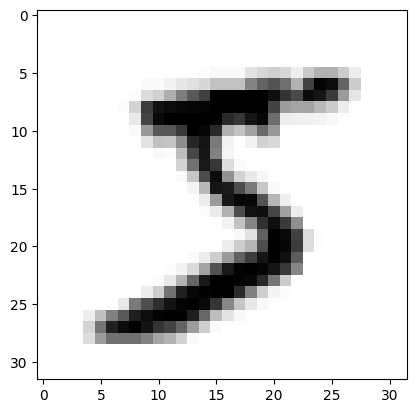

In [ ]:
plt.imshow(data_train_normalized_reversed[0][0][0].numpy(),cmap='gray')

In [ ]:
data_train_normalized_reversed[0][0][0].numpy().shape

(32, 32)

## 定義模型

In [ ]:
class Model:
  def __init__(self, Net):
    self.net = Net().to(DEVICE)
    self.weights = dict()
    self.criterion = nn.CrossEntropyLoss()
    self.optimizer = optim.Adam(self.net.parameters(), lr=2e-3)
    self.accs,self.losses=[],[]
    self.Net = Net


  def train(self, data_train_loader, epoch):
    self.net.train()
    self.accs,self.losses=[],[]
    for e in range(epoch):
        print(f'Epoch [{e + 1}/ {epoch}]')
        loop = tqdm(data_train_loader, leave=True)
        for i, (images, labels) in enumerate(loop):
            self.optimizer.zero_grad()

            output = self.net(images)

            loss = self.criterion(output, labels)

            loss.backward()
            self.optimizer.step()

            pred_labels = torch.argmax(output,dim=1) #找出擁有最大機率值的類別，即為模型的預測結果
            acc = 100.0 * (pred_labels == labels).sum() / labels.shape[0] #計算預測準確率
            self.accs.append(acc.detach().item())
            self.losses.append(loss.detach().item())
            loop.set_postfix(
                Loss = round(loss.detach().item(), 4),
                accuracy = round(acc.detach().item(), 4)
            )

  def test(self, data_test_loader):
    self.net.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad(): # disable gradient calculation for efficiency
      for images, labels in data_test_loader:
        # Prediction
        output = self.net(images)

        # Compute loss & accuracy
        test_loss += self.criterion(output, labels).item()
        pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        pred_labels = torch.argmax(output,dim=1) #找出擁有最大機率值的類別，即為模型的預測結果
        correct += (pred_labels == labels).sum() / labels.shape[0]  #計算預測正確數量

      test_loss /= len(data_test_loader)
      correct /= len(data_test_loader)

      # Log testing info
      print('\nTest set: Average loss: {:.4f}, Accuracy: {:.2f}%\n'.format(
          test_loss, 100. * correct))

  def show_LossAcc(self):
    plt.figure(figsize=(10,7))
    plt.xlabel("Training batch", fontsize=16)
    plt.ylabel("Loss", fontsize=16)
    plt.plot(self.losses)

    plt.figure(figsize=(10,7))
    plt.xlabel("Training batch", fontsize=16)
    plt.ylabel("Training accuracy", fontsize=16)
    plt.plot(self.accs)

  def get_weights(self):
    self.net.eval()

    # Display all model layer weights
    for name, para in self.net.named_parameters():
      self.weights[name] = para
      print('{}: {}'.format(name, para.shape))

  def build_reverse_net(self):
    self.reverse_net = Model(self.Net)
    self.get_weights()
    # Build a new model
    reverse_weight = self.reverse_net.net.state_dict()
    reverse_weight.update(self.weights)
    self.reverse_net.net.load_state_dict(reverse_weight)

    self.reverse_net.net.c1_1.c1.weight.data = -self.weights['c1_1.c1.weight']

  def build_new_net(self):
    self.new_net = Model(self.Net)
    self.get_weights()
    # Build a new model
    new_weight = self.new_net.net.state_dict()
    new_weight.update(self.weights)
    self.new_net.net.load_state_dict(new_weight)

    # 將一正一反的權重合併
    combined_weights = torch.cat((self.weights['c1_1.c1.weight'], -self.weights['c1_1.c1.weight']),  dim=0)

    # 創建新的卷積層，修改權重
    new_conv_layer = nn.Conv2d(1, 12, kernel_size=(5, 5), stride=(1, 1))
    new_conv_layer.weight.data = combined_weights
    new_conv_layer2 = nn.Conv2d(12, 16, kernel_size=(5, 5), stride=(1, 1))
    new_conv_layer2.weight.data = self.weights['c2_1.c3.weight'].repeat(1, 2, 1, 1)

    # 將新的卷積層添加進去
    self.new_net.net.c1_1.c1 = new_conv_layer
    self.new_net.net.c2_1.c3 = new_conv_layer2

    for param in self.new_net.net.c1_1.c1.parameters():
      param.requires_grad = False



# 原始LeNet5模型

In [ ]:
model = Model(LeNet5)

In [ ]:
model.train(data_train_loader, epoch=5)

Epoch [1/ 5]


  0%|          | 0/235 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 235/235 [00:30<00:00,  7.77it/s, Loss=0.0699, accuracy=99]


Epoch [2/ 5]


 61%|██████▏   | 144/235 [00:20<00:12,  7.14it/s, Loss=0.0568, accuracy=97.7]


KeyboardInterrupt: ignored

## 測試模型

In [ ]:
model.test(data_test_loader)
model.test(data_test_reversed_loader)

In [ ]:
list(data_test_loader)[0][0].shape

torch.Size([1024, 1, 32, 32])

In [ ]:
with torch.no_grad(): # disable gradient calculation for efficiency
  output = model.net(torch.unsqueeze(list(data_test_loader)[0][0][0], 0))
  print(output, torch.argmax(output,dim=1), list(data_test_loader)[0][1][0])

tensor([[-1223.7183,  -763.8355,  -136.5607,   563.1957,  -704.7407,  -435.3013,
         -3337.0332,  2852.5789,   -79.5872,   579.9915]]) tensor([7]) tensor(7) tensor([7])


## 權重變換實驗
https://clay-atlas.com/blog/2020/06/13/pytorch-cn-note-how-to-extract-model-layer-or-weights/

### 讀取權重

In [ ]:
model.net.eval()

# Display all model layer weights
weights = dict()
for name, para in model.net.named_parameters():
  weights[name] = para
  print('{}: {}'.format(name, para.shape))

c1_1.c1.weight: torch.Size([6, 1, 5, 5])
c1_1.c1.bias: torch.Size([6])
c2_1.c3.weight: torch.Size([16, 6, 5, 5])
c2_1.c3.bias: torch.Size([16])
f3.f5.weight: torch.Size([120, 400])
f3.f5.bias: torch.Size([120])
f4.f6.weight: torch.Size([84, 120])
f4.f6.bias: torch.Size([84])
output.weight: torch.Size([10, 84])
output.bias: torch.Size([10])


### 第一層權重加上負號

In [ ]:
# Build a new model
reversed_model = Model(LeNet5)
reversed_model_weight = reversed_model.net.state_dict()
reversed_model_weight.update(weights)
reversed_model.net.load_state_dict(reversed_model_weight)

<All keys matched successfully>

In [ ]:
reversed_model.net.c1_1.c1.weight.data = -weights['c1_1.c1.weight']

In [ ]:
reversed_model.test(data_test_loader)
reversed_model.test(data_test_reversed_loader)

Test set: Average loss: 30.4961, Accuracy: 20.72%

Test set: Average loss: 30.0117, Accuracy: 12.71%



In [ ]:
model.net.c1.c1.weight.data

In [ ]:
reversed_model.net.c1.c1.weight.data

### kernel數量增加一倍(同時包含原始權重、加負號權重)

In [ ]:
# Build a new model
new_model = Model(LeNet5)
new_model_weight = model.net.state_dict()
new_model_weight.update(weights)
new_model.net.load_state_dict(new_model_weight)

<All keys matched successfully>

In [ ]:
# 將一正一反的權重合併
combined_weights = torch.cat((weights['c1_1.c1.weight'], -weights['c1_1.c1.weight']),  dim=0)

# 創建新的卷積層，修改權重
new_conv_layer = nn.Conv2d(1, 12, kernel_size=(5, 5), stride=(1, 1))
new_conv_layer.weight.data = combined_weights
new_conv_layer2 = nn.Conv2d(12, 16, kernel_size=(5, 5), stride=(1, 1))
new_conv_layer2.weight.data = model.net.c2_1.c3.weight.data.repeat(1, 2, 1, 1)

# 將新的卷積層添加進去
new_model.net.c1_1.c1 = new_conv_layer
new_model.net.c2_1.c3 = new_conv_layer2

In [ ]:
# 將這兩個張量在第一個維度上進行連接
combined_weights = torch.cat((weights['c1_1.c1.weight'], -weights['c1_1.c1.weight']),  dim=0)
# combined_bias = torch.cat((weights['c1.c1.bias'], weights['c1.c1.bias']),  dim=0)

# 創建新的卷積層，使用負值作為權重
new_conv_layer = nn.Conv2d(1, 12, kernel_size=(5, 5), stride=(1, 1))
new_conv_layer.weight.data = combined_weights
# new_conv_layer.bias.data = combined_bias
new_conv_layer2 = nn.Conv2d(12, 16, kernel_size=(5, 5), stride=(1, 1))
# new_conv_layer2.weight.data = torch.cat((model.net.c2.c3.weight.data, -model.net.c2.c3.weight.data),  dim=1)
new_conv_layer2.weight.data = model.net.c2_1.c3.weight.data.repeat(1, 2, 1, 1)
# new_conv_layer2.bias.data = normalized_reversed_model.net.c2.c3.bias.data

# 修改原始模型的第一層，將新的卷積層添加進去
new_model.net.c1_1.c1 = new_conv_layer
new_model.net.c2_1.c3 = new_conv_layer2

In [ ]:
for param in new_model.net.c1_1.c1.parameters():
    param.requires_grad = False

In [ ]:
new_model.train(data_train_loader, epoch=2)

Epoch [1/ 2]


100%|██████████| 235/235 [00:25<00:00,  9.16it/s, Loss=0.0631, accuracy=96.9]


Epoch [2/ 2]


100%|██████████| 235/235 [00:23<00:00,  9.86it/s, Loss=0.109, accuracy=95.8]


In [ ]:
new_model.test(data_test_loader)
new_model.test(data_test_reversed_loader)

Test set: Average loss: 0.1019, Accuracy: 96.78%

Test set: Average loss: 5.1623, Accuracy: 20.18%



In [ ]:
new_model.test(data_train_reversed_loader)


Test set: Average loss: 0.0729, Accuracy: 97.66%



In [ ]:
with torch.no_grad(): # disable gradient calculation for efficiency
  output = new_model.net(torch.unsqueeze(list(data_test_loader)[0][0][0], 0))
  print(output, torch.argmax(output,dim=1), list(data_test_loader)[0][1][0])

tensor([[ -6.2544,  -0.8711,   1.6126,  -1.6375,   0.5595,  -7.9067, -15.2090,
          17.4985,  -3.7678,   0.7553]]) tensor([7]) tensor(7)


# 球面平移模型

In [ ]:
Translated_model = Model(Translated_LeNet5)

In [ ]:
Translated_model.train(data_train_loader, epoch=5)

Epoch [1/ 5]


100%|██████████| 235/235 [00:49<00:00,  4.78it/s, Loss=0.151, accuracy=94.8]


Epoch [2/ 5]


100%|██████████| 235/235 [00:37<00:00,  6.26it/s, Loss=0.0257, accuracy=99]


Epoch [3/ 5]


100%|██████████| 235/235 [00:37<00:00,  6.33it/s, Loss=0.0088, accuracy=100]


Epoch [4/ 5]


100%|██████████| 235/235 [00:36<00:00,  6.47it/s, Loss=0.0461, accuracy=99]


Epoch [5/ 5]


100%|██████████| 235/235 [00:37<00:00,  6.26it/s, Loss=0.0111, accuracy=100]


## 測試模型

In [ ]:
Translated_model.test(data_test_loader)
Translated_model.test(data_test_reversed_loader)


Test set: Average loss: 0.0444, Accuracy: 98.76%


Test set: Average loss: 3.3772, Accuracy: 32.84%



In [ ]:
list(data_test_loader)[0][0].shape

torch.Size([1024, 1, 32, 32])

In [ ]:
with torch.no_grad(): # disable gradient calculation for efficiency
  output = model.net(torch.unsqueeze(list(data_test_loader)[0][0][0], 0))
  print(output, torch.argmax(output,dim=1), list(data_test_loader)[0][1][0])

tensor([[-1223.7183,  -763.8355,  -136.5607,   563.1957,  -704.7407,  -435.3013,
         -3337.0332,  2852.5789,   -79.5872,   579.9915]]) tensor([7]) tensor(7) tensor([7])


## 權重變換實驗
https://clay-atlas.com/blog/2020/06/13/pytorch-cn-note-how-to-extract-model-layer-or-weights/

### 第一層權重加上負號

In [ ]:
Translated_model.build_reverse_net()

c1_1.c1.weight: torch.Size([6, 1, 5, 5])
c1_1.c1.bias: torch.Size([6])
c2_1.c3.weight: torch.Size([16, 6, 5, 5])
c2_1.c3.bias: torch.Size([16])
f3.f5.weight: torch.Size([120, 400])
f3.f5.bias: torch.Size([120])
f4.f6.weight: torch.Size([84, 120])
f4.f6.bias: torch.Size([84])
output.weight: torch.Size([10, 84])
output.bias: torch.Size([10])


In [ ]:
Translated_model.reverse_net.test(data_test_loader)
Translated_model.reverse_net.test(data_test_reversed_loader)


Test set: Average loss: 3.3772, Accuracy: 32.84%


Test set: Average loss: 0.0444, Accuracy: 98.76%



### kernel數量增加一倍(同時包含原始權重、加負號權重)

In [ ]:
Translated_model.build_new_net()

c1_1.c1.weight: torch.Size([6, 1, 5, 5])
c1_1.c1.bias: torch.Size([6])
c2_1.c3.weight: torch.Size([16, 6, 5, 5])
c2_1.c3.bias: torch.Size([16])
f3.f5.weight: torch.Size([120, 400])
f3.f5.bias: torch.Size([120])
f4.f6.weight: torch.Size([84, 120])
f4.f6.bias: torch.Size([84])
output.weight: torch.Size([10, 84])
output.bias: torch.Size([10])


In [ ]:
Translated_model.new_net.test(data_test_loader)
Translated_model.new_net.test(data_test_reversed_loader)


Test set: Average loss: 1.0306, Accuracy: 62.98%


Test set: Average loss: 1.0306, Accuracy: 62.98%



In [ ]:
Translated_model.new_net.train(data_train_loader, epoch=2)

Epoch [1/ 2]


100%|██████████| 235/235 [00:34<00:00,  6.84it/s, Loss=0.118, accuracy=96.9]


Epoch [2/ 2]


100%|██████████| 235/235 [00:35<00:00,  6.66it/s, Loss=0.0947, accuracy=97.9]


In [ ]:
Translated_model.new_net.test(data_test_loader)
Translated_model.new_net.test(data_test_reversed_loader)


Test set: Average loss: 0.1130, Accuracy: 96.36%


Test set: Average loss: 0.1129, Accuracy: 96.37%



## 權重變換實驗
https://clay-atlas.com/blog/2020/06/13/pytorch-cn-note-how-to-extract-model-layer-or-weights/

### 讀取權重

In [ ]:
Translated_model.net.eval()

# Display all model layer weights
weights = dict()
for name, para in Translated_model.net.named_parameters():
  weights[name] = para
  print('{}: {}'.format(name, para.shape))

c1_1.c1.weight: torch.Size([6, 1, 5, 5])
c1_1.c1.bias: torch.Size([6])
c2.c3.weight: torch.Size([16, 6, 5, 5])
c2.c3.bias: torch.Size([16])
f3.f5.weight: torch.Size([120, 400])
f3.f5.bias: torch.Size([120])
f4.f6.weight: torch.Size([84, 120])
f4.f6.bias: torch.Size([84])
output.weight: torch.Size([10, 84])
output.bias: torch.Size([10])


### 第一層權重加上負號

In [ ]:
# Build a new model
reversed_Translated_model = Model(Translated_LeNet5)
reversed_Translated_model_weight = reversed_Translated_model.net.state_dict()
reversed_Translated_model_weight.update(weights)
reversed_Translated_model.net.load_state_dict(reversed_Translated_model_weight)

<All keys matched successfully>

In [ ]:
reversed_Translated_model.net.c1_1.c1.weight.data = -weights['c1_1.c1.weight']

In [ ]:
reversed_Translated_model.test(data_test_loader)
reversed_Translated_model.test(data_test_reversed_loader)

Test set: Average loss: 3.6962, Accuracy: 20.17%

Test set: Average loss: 0.0398, Accuracy: 98.71%



### kernel數量增加一倍(同時包含原始權重、加負號權重)

In [ ]:
# Build a new model
new_Translated_model = Model(Translated_LeNet5)
new_Translated_model_weight = new_Translated_model.net.state_dict()
new_Translated_model_weight.update(weights)
new_Translated_model.net.load_state_dict(new_Translated_model_weight)

<All keys matched successfully>

In [ ]:
# 將一正一反的權重合併
combined_weights = torch.cat((weights['c1_1.c1.weight'], -weights['c1_1.c1.weight']),  dim=0)

# 創建新的卷積層，修改權重
new_conv_layer = nn.Conv2d(1, 12, kernel_size=(5, 5), stride=(1, 1))
new_conv_layer.weight.data = combined_weights
new_conv_layer2 = nn.Conv2d(12, 16, kernel_size=(5, 5), stride=(1, 1))
new_conv_layer2.weight.data = weights['c2.c3.weight'].repeat(1, 2, 1, 1)

# 將新的卷積層添加進去
new_Translated_model.net.c1_1.c1 = new_conv_layer
new_Translated_model.net.c2.c3 = new_conv_layer2

In [ ]:
for param in new_Translated_model.net.c1_1.c1.parameters():
    param.requires_grad = False

In [ ]:
new_Translated_model.train(data_train_loader, epoch=5)

Epoch [1/ 5]


100%|██████████| 235/235 [00:39<00:00,  6.01it/s, Loss=0.108, accuracy=95.8]


Epoch [2/ 5]


100%|██████████| 235/235 [00:31<00:00,  7.35it/s, Loss=0.0285, accuracy=100]


Epoch [3/ 5]


100%|██████████| 235/235 [00:36<00:00,  6.46it/s, Loss=0.038, accuracy=99]


Epoch [4/ 5]


100%|██████████| 235/235 [00:37<00:00,  6.31it/s, Loss=0.0385, accuracy=99]


Epoch [5/ 5]


100%|██████████| 235/235 [00:33<00:00,  7.12it/s, Loss=0.0627, accuracy=95.8]


In [ ]:
new_Translated_model.test(data_test_loader)
new_Translated_model.test(data_test_reversed_loader)

Test set: Average loss: 0.1809, Accuracy: 95.71%

Test set: Average loss: 0.1812, Accuracy: 95.71%



In [ ]:
new_model.test(data_train_reversed_loader)


Test set: Average loss: 0.0729, Accuracy: 97.66%



In [ ]:
with torch.no_grad(): # disable gradient calculation for efficiency
  output = new_model.net(torch.unsqueeze(list(data_test_loader)[0][0][0], 0))
  print(output, torch.argmax(output,dim=1), list(data_test_loader)[0][1][0])

tensor([[ -6.2544,  -0.8711,   1.6126,  -1.6375,   0.5595,  -7.9067, -15.2090,
          17.4985,  -3.7678,   0.7553]]) tensor([7]) tensor(7)


# 用正歸化後的資料集訓練

In [ ]:
normalized_model = Model(Translated_LeNet5)

In [ ]:
normalized_model.train(data_train_normalized_loader, epoch=5)

Epoch [1/ 5]


100%|██████████| 235/235 [00:29<00:00,  7.94it/s, Loss=0.153, accuracy=93.8]


Epoch [2/ 5]


100%|██████████| 235/235 [00:30<00:00,  7.65it/s, Loss=0.033, accuracy=99]


Epoch [3/ 5]


100%|██████████| 235/235 [00:32<00:00,  7.26it/s, Loss=0.0149, accuracy=100]


Epoch [4/ 5]


100%|██████████| 235/235 [00:29<00:00,  8.00it/s, Loss=0.0577, accuracy=97.9]


Epoch [5/ 5]


100%|██████████| 235/235 [00:29<00:00,  7.98it/s, Loss=0.154, accuracy=97.9]


## 測試模型

In [ ]:
normalized_model.test(data_test_normalized_loader)
normalized_model.test(data_test_normalized_reversed_loader)


Test set: Average loss: 0.0327, Accuracy: 98.76%


Test set: Average loss: 2.8626, Accuracy: 40.25%



## 權重變換實驗
https://clay-atlas.com/blog/2020/06/13/pytorch-cn-note-how-to-extract-model-layer-or-weights/

### 第一層權重加上負號

In [ ]:
normalized_model.build_reverse_net()

c1_1.c1.weight: torch.Size([6, 1, 5, 5])
c1_1.c1.bias: torch.Size([6])
c2_1.c3.weight: torch.Size([16, 6, 5, 5])
c2_1.c3.bias: torch.Size([16])
f3.f5.weight: torch.Size([120, 400])
f3.f5.bias: torch.Size([120])
f4.f6.weight: torch.Size([84, 120])
f4.f6.bias: torch.Size([84])
output.weight: torch.Size([10, 84])
output.bias: torch.Size([10])


In [ ]:
normalized_model.reverse_net.test(data_test_normalized_loader)
normalized_model.reverse_net.test(data_test_normalized_reversed_loader)


Test set: Average loss: 1.9791, Accuracy: 51.64%


Test set: Average loss: 0.0360, Accuracy: 98.66%



### kernel數量增加一倍(同時包含原始權重、加負號權重)

In [ ]:
normalized_model.build_new_net()

c1_1.c1.weight: torch.Size([6, 1, 5, 5])
c1_1.c1.bias: torch.Size([6])
c2_1.c3.weight: torch.Size([16, 6, 5, 5])
c2_1.c3.bias: torch.Size([16])
f3.f5.weight: torch.Size([120, 400])
f3.f5.bias: torch.Size([120])
f4.f6.weight: torch.Size([84, 120])
f4.f6.bias: torch.Size([84])
output.weight: torch.Size([10, 84])
output.bias: torch.Size([10])


In [ ]:
normalized_model.new_net.train(data_train_normalized_loader, epoch=2)

Epoch [1/ 2]


100%|██████████| 235/235 [00:29<00:00,  7.93it/s, Loss=0.0394, accuracy=99]


Epoch [2/ 2]


100%|██████████| 235/235 [00:28<00:00,  8.15it/s, Loss=0.0726, accuracy=97.9]


In [ ]:
normalized_model.new_net.test(data_test_normalized_loader)
normalized_model.new_net.test(data_test_normalized_reversed_loader)


Test set: Average loss: 0.0463, Accuracy: 98.55%


Test set: Average loss: 0.0504, Accuracy: 98.43%



# 單位向量

In [ ]:
normalized_model = Model(LeNet5)

In [ ]:
normalized_model.train(data_train_loader, epoch=5)

Epoch [1/ 5]


100%|██████████| 235/235 [00:55<00:00,  4.24it/s, Loss=0.156, accuracy=93.8]


Epoch [2/ 5]


100%|██████████| 235/235 [00:54<00:00,  4.35it/s, Loss=0.0724, accuracy=99]


Epoch [3/ 5]


100%|██████████| 235/235 [00:54<00:00,  4.35it/s, Loss=0.0898, accuracy=97.9]


Epoch [4/ 5]


100%|██████████| 235/235 [00:56<00:00,  4.16it/s, Loss=0.0168, accuracy=100]


Epoch [5/ 5]


100%|██████████| 235/235 [00:55<00:00,  4.25it/s, Loss=0.0728, accuracy=99]


In [ ]:
normalized_model.show_LossAcc()

## 測試模型

In [ ]:
normalized_model.test(data_test_loader)
normalized_model.test(data_test_reversed_loader)


Test set: Average loss: 0.0411, Accuracy: 98.58%


Test set: Average loss: 2.8554, Accuracy: 29.21%



## 權重變換實驗
https://clay-atlas.com/blog/2020/06/13/pytorch-cn-note-how-to-extract-model-layer-or-weights/

### 第一層權重加上負號

In [ ]:
normalized_model.build_reverse_net()

c1_1.c1.weight: torch.Size([6, 1, 5, 5])
c1_1.c1.bias: torch.Size([6])
c2_1.c3.weight: torch.Size([16, 6, 5, 5])
c2_1.c3.bias: torch.Size([16])
f3.f5.weight: torch.Size([120, 400])
f3.f5.bias: torch.Size([120])
f4.f6.weight: torch.Size([84, 120])
f4.f6.bias: torch.Size([84])
output.weight: torch.Size([10, 84])
output.bias: torch.Size([10])
layer_norm2.weight: torch.Size([10, 10])
layer_norm2.bias: torch.Size([10, 10])


In [ ]:
normalized_model.reverse_net.test(data_test_loader)
normalized_model.reverse_net.test(data_test_reversed_loader)


Test set: Average loss: 3.2058, Accuracy: 26.46%


Test set: Average loss: 0.1531, Accuracy: 95.13%



### kernel數量增加一倍(同時包含原始權重、加負號權重)

In [ ]:
normalized_model.build_new_net()

c1_1.c1.weight: torch.Size([6, 1, 5, 5])
c1_1.c1.bias: torch.Size([6])
c2_1.c3.weight: torch.Size([16, 6, 5, 5])
c2_1.c3.bias: torch.Size([16])
f3.f5.weight: torch.Size([120, 400])
f3.f5.bias: torch.Size([120])
f4.f6.weight: torch.Size([84, 120])
f4.f6.bias: torch.Size([84])
output.weight: torch.Size([10, 84])
output.bias: torch.Size([10])
layer_norm2.weight: torch.Size([10, 10])
layer_norm2.bias: torch.Size([10, 10])


In [ ]:
normalized_model.new_net.test(data_test_loader)
normalized_model.new_net.test(data_test_reversed_loader)


Test set: Average loss: 0.7165, Accuracy: 75.16%


Test set: Average loss: 0.9181, Accuracy: 68.08%



訓練權重增加後的模型

In [ ]:
normalized_model.new_net.train(data_train_loader, epoch=2)

Epoch [1/ 2]


100%|██████████| 235/235 [01:00<00:00,  3.86it/s, Loss=0.0474, accuracy=97.9]


Epoch [2/ 2]


100%|██████████| 235/235 [00:58<00:00,  4.02it/s, Loss=0.0575, accuracy=96.9]


In [ ]:
normalized_model.new_net.test(data_test_loader)
normalized_model.new_net.test(data_test_reversed_loader)


Test set: Average loss: 0.0431, Accuracy: 98.52%


Test set: Average loss: 0.1273, Accuracy: 95.67%



# 單位向量

In [ ]:
normalized_model = Model(LeNet5)

In [ ]:
normalized_model.train(data_train_loader, epoch=5)

Epoch [1/ 5]


100%|██████████| 235/235 [01:01<00:00,  3.83it/s, Loss=0.189, accuracy=93.8]


Epoch [2/ 5]


100%|██████████| 235/235 [00:58<00:00,  4.03it/s, Loss=0.0429, accuracy=97.9]


Epoch [3/ 5]


100%|██████████| 235/235 [00:57<00:00,  4.09it/s, Loss=0.0518, accuracy=97.9]


Epoch [4/ 5]


100%|██████████| 235/235 [00:59<00:00,  3.94it/s, Loss=0.019, accuracy=100]


Epoch [5/ 5]


100%|██████████| 235/235 [00:58<00:00,  4.05it/s, Loss=0.014, accuracy=99]


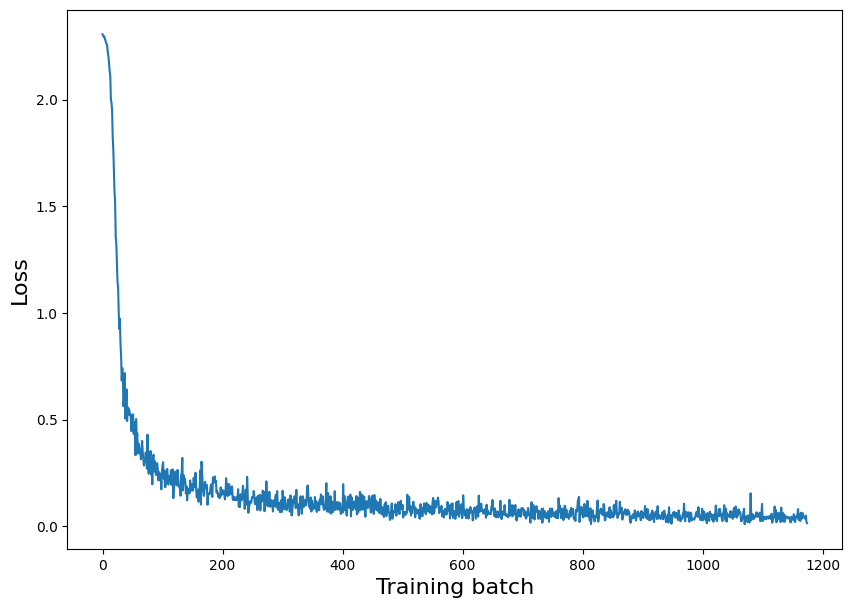

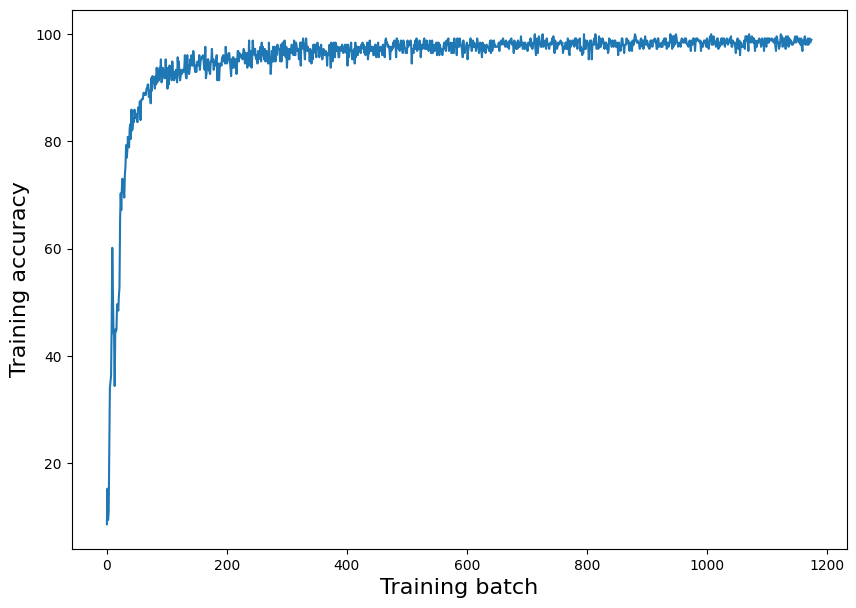

In [ ]:
normalized_model.show_LossAcc()

## 測試模型

In [ ]:
normalized_model.test(data_test_loader)
normalized_model.test(data_test_reversed_loader)


Test set: Average loss: 0.0399, Accuracy: 98.70%


Test set: Average loss: 2.7847, Accuracy: 30.61%



## 權重變換實驗
https://clay-atlas.com/blog/2020/06/13/pytorch-cn-note-how-to-extract-model-layer-or-weights/

### 第一層權重加上負號

In [ ]:
normalized_model.build_reverse_net()

c1_1.c1.weight: torch.Size([6, 1, 5, 5])
c1_1.c1.bias: torch.Size([6])
c2_1.c3.weight: torch.Size([16, 6, 5, 5])
c2_1.c3.bias: torch.Size([16])
f3.f5.weight: torch.Size([120, 400])
f3.f5.bias: torch.Size([120])
f4.f6.weight: torch.Size([84, 120])
f4.f6.bias: torch.Size([84])
output.weight: torch.Size([10, 84])
output.bias: torch.Size([10])
layer_norm2.weight: torch.Size([10, 10])
layer_norm2.bias: torch.Size([10, 10])


In [ ]:
normalized_model.reverse_net.test(data_test_loader)
normalized_model.reverse_net.test(data_test_reversed_loader)


Test set: Average loss: 3.2805, Accuracy: 32.98%


Test set: Average loss: 0.0921, Accuracy: 97.34%



### kernel數量增加一倍(同時包含原始權重、加負號權重)

In [ ]:
normalized_model.build_new_net()

c1_1.c1.weight: torch.Size([6, 1, 5, 5])
c1_1.c1.bias: torch.Size([6])
c2_1.c3.weight: torch.Size([16, 6, 5, 5])
c2_1.c3.bias: torch.Size([16])
f3.f5.weight: torch.Size([120, 400])
f3.f5.bias: torch.Size([120])
f4.f6.weight: torch.Size([84, 120])
f4.f6.bias: torch.Size([84])
output.weight: torch.Size([10, 84])
output.bias: torch.Size([10])
layer_norm2.weight: torch.Size([10, 10])
layer_norm2.bias: torch.Size([10, 10])


In [ ]:
normalized_model.new_net.test(data_test_loader)
normalized_model.new_net.test(data_test_reversed_loader)


Test set: Average loss: 1.6355, Accuracy: 57.41%


Test set: Average loss: 0.9965, Accuracy: 68.90%



訓練權重增加後的模型

In [ ]:
normalized_model.new_net.train(data_train_loader, epoch=2)

Epoch [1/ 2]


100%|██████████| 235/235 [00:57<00:00,  4.11it/s, Loss=0.0225, accuracy=100]


Epoch [2/ 2]


100%|██████████| 235/235 [00:55<00:00,  4.22it/s, Loss=0.0781, accuracy=95.8]


In [ ]:
normalized_model.new_net.test(data_test_loader)
normalized_model.new_net.test(data_test_reversed_loader)


Test set: Average loss: 0.0628, Accuracy: 97.97%


Test set: Average loss: 0.1681, Accuracy: 94.44%



# 其他

In [ ]:
def test(data_test_loader):
  net.eval()
  preds=[]
  test_loss = 0
  correct = 0
  with torch.no_grad(): # disable gradient calculation for efficiency
    for images, labels in data_test_loader:
      # Prediction
      output = net(images)

      # Compute loss & accuracy
      test_loss += criterion(output, labels).item()
      pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
      pred_labels = torch.argmax(output,dim=1) #找出擁有最大機率值的類別，即為模型的預測結果
      correct += (pred_labels == labels).sum() / labels.shape[0] #計算預測準確率

    test_loss /= len(data_test_loader)
    correct /= len(data_test_loader)

    # Log testing info
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(data_test_loader), 100. * correct))

In [ ]:
test(data_test_normalized_reversed_loader)


Test set: Average loss: 2.6113, Accuracy: 0.3476482927799225/10 (34.76%)



In [ ]:
def train_and_test(epoch):
    train(epoch)
    test()

    dummy_input = torch.randn(1, 1, 32, 32, requires_grad=True)
    torch.onnx.export(net, dummy_input, "lenet.onnx")

    onnx_model = onnx.load("lenet.onnx")
    onnx.checker.check_model(onnx_model)

In [ ]:
net = LeNet5()
net.train()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=2e-3)

In [ ]:
accs,losses=[],[]
for epoch in range(n_epoch):
    e = epoch
    print(f'Epoch [{e + 1}/ {n_epoch}]')
    loop = tqdm(data_train_normalized_loader, leave=True)
    for i, (images, labels) in enumerate(loop):
        optimizer.zero_grad()

        output = net(images)

        loss = criterion(output, labels)

        loss.backward()
        optimizer.step()

        pred_labels = torch.argmax(output,dim=1) #找出擁有最大機率值的類別，即為模型的預測結果
        acc = 100.0 * (pred_labels == labels).sum() / labels.shape[0] #計算預測準確率
        accs.append(acc.detach().item())
        losses.append(loss.detach().item())
        loop.set_postfix(
            Loss = round(loss.detach().item(), 4),
            accuracy = round(acc.detach().item(), 4)
        )

Epoch [1/ 5]


100%|██████████| 235/235 [00:26<00:00,  8.73it/s, Loss=0.0902, accuracy=97.9]


Epoch [2/ 5]


100%|██████████| 235/235 [00:39<00:00,  6.00it/s, Loss=0.0792, accuracy=95.8]


Epoch [3/ 5]


100%|██████████| 235/235 [00:27<00:00,  8.43it/s, Loss=0.074, accuracy=96.9]


Epoch [4/ 5]


100%|██████████| 235/235 [00:34<00:00,  6.78it/s, Loss=0.0412, accuracy=97.9]


Epoch [5/ 5]


100%|██████████| 235/235 [00:38<00:00,  6.05it/s, Loss=0.0103, accuracy=100]


In [ ]:
plt.figure(figsize=(10,7))
plt.xlabel("Training batch", fontsize=16)
plt.ylabel("Loss", fontsize=16)
plt.plot(losses)

plt.figure(figsize=(10,7))
plt.xlabel("Training batch", fontsize=16)
plt.ylabel("Training accuracy", fontsize=16)
plt.plot(accs)

In [ ]:

# import visdom
# import onnx

# viz = visdom.Visdom()


cur_batch_win = None
cur_batch_win_opts = {
    'title': 'Epoch Loss Trace',
    'xlabel': 'Batch Number',
    'ylabel': 'Loss',
    'width': 1200,
    'height': 600,
}


def train(epoch):
    global cur_batch_win
    net.train()
    loss_list, batch_list = [], []
    for i, (images, labels) in enumerate(data_train_loader):
        optimizer.zero_grad()

        output = net(images)

        loss = criterion(output, labels)

        loss_list.append(loss.detach().cpu().item())
        batch_list.append(i+1)

        if i % 10 == 0:
            print('Train - Epoch %d, Batch: %d, Loss: %f' % (epoch, i, loss.detach().cpu().item()))

        # Update Visualization
        if viz.check_connection():
            cur_batch_win = viz.line(torch.Tensor(loss_list), torch.Tensor(batch_list),
                                     win=cur_batch_win, name='current_batch_loss',
                                     update=(None if cur_batch_win is None else 'replace'),
                                     opts=cur_batch_win_opts)

        loss.backward()
        optimizer.step()


def test():
    net.eval()
    total_correct = 0
    avg_loss = 0.0
    for i, (images, labels) in enumerate(data_test_loader):
        output = net(images)
        avg_loss += criterion(output, labels).sum()
        pred = output.detach().max(1)[1]
        total_correct += pred.eq(labels.view_as(pred)).sum()

    avg_loss /= len(data_test)
    print('Test Avg. Loss: %f, Accuracy: %f' % (avg_loss.detach().cpu().item(), float(total_correct) / len(data_test)))


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
